In [1]:
import numpy as np
np.random.seed(0)
import torch
torch.manual_seed(0)
import random
random.seed(0)
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.nn import Module
import cv2
import os
import torchvision
import time
import socket
import matplotlib.pyplot as plt


In [2]:
class HasFaceNN(Module):
    def __init__(self):
        super(HasFaceNN, self).__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(3,6,5),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        self.enc2 = nn.Sequential(
            nn.Linear(6*62*62,128),
            nn.Sigmoid(),
            nn.Linear(128, 32),
            nn.Sigmoid(),
            nn.Linear(32, 8),
            nn.Sigmoid(),
            nn.Linear(8, 1),
            nn.ReLU()
            )
    def encoder(self,image):
        # WRITE ENCODER ARCHITECTURE HERE
        code = self.enc1(image)
        code = code.view(-1, 6*62*62)
        code = self.enc2(code)
        return code
    
    def forward(self,image):
        # PUT IT TOGETHER HERE
        code = self.encoder(image)
        return code


class FacePoseNN(Module):
    def __init__(self):
        super(FacePoseNN, self).__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(3,16,5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16,64,5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64,32,5),
            nn.ReLU()
            )
        self.enc2 = nn.Sequential(
            nn.Linear(32*25*25,512),
            nn.ReLU(),
            nn.Linear(512,128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 5)
            )
    def encoder(self,image):
        # WRITE ENCODER ARCHITECTURE HERE
        code = self.enc1(image)
        code = code.view(-1, 32*25*25)
        code = self.enc2(code)
        return code
    
    def forward(self,image):
        # PUT IT TOGETHER HERE
        code = self.encoder(image)
        return code


In [3]:
hasFaceModel = HasFaceNN()
hasFaceModel = torch.load("./hasFace")
hasFaceModel.eval()

facePosModel = FacePoseNN()
facePosModel = torch.load("./facePos")
facePosModel.eval()

FacePoseNN(
  (enc1): Sequential(
    (0): Conv2d(3, 16, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 64, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 32, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
  )
  (enc2): Sequential(
    (0): Linear(in_features=20000, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=5, bias=True)
  )
)

In [52]:
cam = cv2.VideoCapture(1)
cam.set(3, 640)
cam.set(4, 640)

while (cam.isOpened()):
    tmr_start = time.time()
    succ, img = cam.read()
    img = cv2.resize(img, (128,128))
    
    trans = torchvision.transforms.ToTensor()
    test_img = trans(img)
    test_img = test_img.unsqueeze(0)

    res_hasFace = hasFaceModel(test_img).item()
    if (res_hasFace > 0.5):
        res_facePose = facePosModel(test_img).detach().numpy()
        res_facePose *= np.array([128,128,180/3.14159,180/3.14159,180/3.14159])
        res_facePose = res_facePose.astype(int)
        #print(res_facePose[0])
        ptLeftTop = (res_facePose[0,0] - 25, res_facePose[0,1] - 25)
        ptRightBottom = (res_facePose[0,0] + 25, res_facePose[0,1] + 25)
        point_color = (0, 255, 0) # BGR
        thickness = 1
        cv2.rectangle(img, ptLeftTop, ptRightBottom, point_color, thickness)
    #end if
    
    cv2.imshow("test", img)
    keyPress = cv2.waitKey(1)
    if (keyPress == ord('s')):
        break;
    #endif
    
    tmr_end = time.time()
    while (tmr_end - tmr_start < 0.0333):
        tmr_end = time.time()
    #end while
#end while
cam.release()

#cv2.imshow("test", img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

cv2.destroyAllWindows()

In [4]:
# camera record

cam = cv2.VideoCapture(1)
cam.set(3, 640)
cam.set(4, 640)
flag_startCap = 0
capidx = 0
resval = []

while (cam.isOpened()):
    tmr_start = time.time()
    succ, img = cam.read()
    #img = cv2.resize(img, (128,128))
    if (flag_startCap == 1):
        cv2.imwrite("./video/" + str(capidx) + ".png", img)
        capidx += 1
    #endif
    
    cv2.imshow("test", img)
    
    keyPress = cv2.waitKey(1)
    if (keyPress == ord('r')):
        flag_startCap = 1
    elif (keyPress == ord('e')):
        flag_startCap = 0
        break;
    #endif
    
    tmr_end = time.time()
    while (tmr_end - tmr_start < 0.0333):
        tmr_end = time.time()
    #end while
#end while
cam.release()

#cv2.imshow("test", img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

cv2.destroyAllWindows()

In [57]:
cam = cv2.VideoCapture(1)
cam.set(3, 640)
cam.set(4, 640)
flag_startCap = 0
capidx = 0
resval = []

while (cam.isOpened()):
    tmr_start = time.time()
    succ, img = cam.read()
    img = cv2.resize(img, (128,128))
    if (flag_startCap == 1):
        cv2.imwrite("./video/" + str(capidx) + ".png", img)
        capidx += 1
    #endif
    
    trans = torchvision.transforms.ToTensor()
    test_img = trans(img)
    test_img = test_img.unsqueeze(0)

    res_hasFace = hasFaceModel(test_img).item()
    if (res_hasFace > 0.5):
        res_facePose = facePosModel(test_img).detach().numpy()
        raw_resval = res_facePose[0]
        if (flag_startCap == 1):
            resval.append(raw_resval)
        #endif
        
        res_facePose *= np.array([128,128,180/3.14159,180/3.14159,180/3.14159])
        res_facePose = res_facePose.astype(int)
        #print(res_facePose[0])
        ptLeftTop = (res_facePose[0,0] - 25, res_facePose[0,1] - 25)
        ptRightBottom = (res_facePose[0,0] + 25, res_facePose[0,1] + 25)
        point_color = (0, 255, 0) # BGR
        thickness = 1
        cv2.rectangle(img, ptLeftTop, ptRightBottom, point_color, thickness)
    else:
        if (flag_startCap == 1):
            resval.append(np.array([0,0,0,0,0]))
        #endif
    #end if
    
    cv2.imshow("test", img)
    keyPress = cv2.waitKey(1)
    if (keyPress == ord('r')):
        flag_startCap = 1
    elif (keyPress == ord('e')):
        flag_startCap = 0
        break;
    #endif
    
    tmr_end = time.time()
    while (tmr_end - tmr_start < 0.0333):
        tmr_end = time.time()
    #end while
#end while
cam.release()

#cv2.imshow("test", img)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

cv2.destroyAllWindows()
resval = np.array(resval)
np.savetxt('./script.txt', resval, delimiter=',')

In [34]:
# test tcp socket
send = np.array([1.0,2.0,3.0,4.0])
print(send.tobytes())


tcp_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
tcp_socket.connect(('192.168.0.128', 9979))
tcp_socket.send(send.tobytes())

tcp_socket.close()


[[61.149387  66.0958    -3.31437    1.0765035  3.7251844]]


In [4]:
sendOutData = np.zeros(11)
sendOutData = sendOutData.astype(np.float32)
print(sendOutData)
# 0 has_face
# 1 face_pos_x
# 2 face_pos_y
# 3 face_rect_r
# 4 head_rx
# 5 head_ry
# 6 head_rz
# 7 blink
# 8 smile
# 9 mouth_a
# 10 serious


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [5]:
# NN definition
class HasFaceNN(Module):
    def __init__(self):
        super(HasFaceNN, self).__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(3,6,5),
            nn.ReLU(),
            nn.MaxPool2d(2)
            )
        self.enc2 = nn.Sequential(
            nn.Linear(6*62*62,128),
            nn.Sigmoid(),
            nn.Linear(128, 32),
            nn.Sigmoid(),
            nn.Linear(32, 8),
            nn.Sigmoid(),
            nn.Linear(8, 1),
            nn.ReLU()
            )
    def encoder(self,image):
        # WRITE ENCODER ARCHITECTURE HERE
        code = self.enc1(image)
        code = code.view(-1, 6*62*62)
        code = self.enc2(code)
        return code
    
    def forward(self,image):
        # PUT IT TOGETHER HERE
        code = self.encoder(image)
        return code

class HasFace2NN(Module):
    def __init__(self):
        super(HasFace2NN, self).__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(3,16,5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16,64,5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64,32,5),
            nn.ReLU()
            )
        self.enc2 = nn.Sequential(
            nn.Linear(32*25*25,256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 4)
            )
    def encoder(self,image):
        # WRITE ENCODER ARCHITECTURE HERE
        code = self.enc1(image)
        code = code.view(-1, 32*25*25)
        code = self.enc2(code)
        return code
    
    def forward(self,image):
        # PUT IT TOGETHER HERE
        code = self.encoder(image)
        return code

class HasFace3NN(Module):
    def __init__(self):
        super(HasFace3NN, self).__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(3,16,5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16,64,5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(64,32,5),
            nn.ReLU()
            )
        self.enc2 = nn.Sequential(
            nn.Linear(32*9*9,512),
            nn.ReLU(),
            nn.Linear(512, 128),
            nn.ReLU(),
            nn.Linear(128, 32),
            nn.ReLU(),
            nn.Linear(32, 3)
            )
    def encoder(self,image):
        # WRITE ENCODER ARCHITECTURE HERE
        code = self.enc1(image)
        code = code.view(-1, 32*9*9)
        code = self.enc2(code)
        return code
    
    def forward(self,image):
        # PUT IT TOGETHER HERE
        code = self.encoder(image)
        return code

class HasFace4NN(Module):
    def __init__(self):
        super(HasFace4NN, self).__init__()
        self.enc1 = nn.Sequential(
            nn.Conv2d(3,24,5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(24,18,5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(18,12,5),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(12,12,5),
            nn.ReLU()
            )
        self.enc2 = nn.Sequential(
            nn.Linear(12*24*24,256),
            nn.ReLU(),
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 4)
            )
    def encoder(self,image):
        # WRITE ENCODER ARCHITECTURE HERE
        code = self.enc1(image)
        code = code.view(-1, 12*24*24)
        code = self.enc2(code)
        return code
    
    def forward(self,image):
        # PUT IT TOGETHER HERE
        code = self.encoder(image)
        return code


In [6]:
# load models
hasFaceModel = HasFaceNN()
hasFaceModel = torch.load("./hasFace")
hasFaceModel.eval()

v2_model1 = HasFace2NN()
v2_model1 = torch.load("./v2_faceRect")
v2_model1.eval()

v2_model2 = HasFace3NN()
v2_model2 = torch.load("./v2_faceRot")
v2_model2.eval()

v2_model3 = HasFace4NN()
v2_model3 = torch.load("./v2_emoji")
v2_model3.eval()

HasFace4NN(
  (enc1): Sequential(
    (0): Conv2d(3, 24, kernel_size=(5, 5), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(24, 18, kernel_size=(5, 5), stride=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(18, 12, kernel_size=(5, 5), stride=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (9): Conv2d(12, 12, kernel_size=(5, 5), stride=(1, 1))
    (10): ReLU()
  )
  (enc2): Sequential(
    (0): Linear(in_features=6912, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=4, bias=True)
  )
)

In [7]:
bufferCount = 0
past_buffer = np.zeros((15,10))

def low_pass(dataIn, k_size, sigma):
    global bufferCount
    global past_buffer
    past_buffer = np.delete(past_buffer, 0, axis = 0)
    past_buffer = np.row_stack((past_buffer, dataIn))
    bufferCount += 1
    if (bufferCount > k_size):
        bufferCount = k_size
    
    res = np.zeros(10)
    weight_sum = 0.0
    for i in range(bufferCount):
        x = bufferCount - i - 0.5
        val = past_buffer[15-bufferCount+i]
        weight = np.exp(-x*x/(2.0*sigma*sigma))/np.sqrt(2.0*3.1416)*sigma
        weight_sum += weight
        res += (weight * val)
    #next
    res /= weight_sum
    return res
#end def

head rotation:
[ 0.0162749   0.0497966  -0.00131192]
smiling:
0.0729281
speaking:
0.02785261
angry:
0.1457562


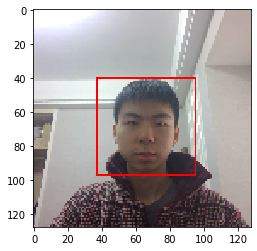

In [15]:
# testing
img = cv2.imread('../head_pos/ss019.png')
    
trans = torchvision.transforms.ToTensor()

sendOutData = np.zeros(11)
sendOutData = sendOutData.astype(np.float32)

resval = []

img128 = cv2.resize(img, (128,128))
test_img128 = trans(img128)
test_img128 = test_img128.unsqueeze(0)
# if has face
res_hasFace = hasFaceModel(test_img128).item()
if (res_hasFace > 0.5):
    sendOutData[0] = res_hasFace
    # face rect
    res_facePose = v2_model1(test_img128).detach().numpy()
    res_facePose = res_facePose[0]
    centy = (res_facePose[0] + res_facePose[1])*0.5
    centx = (res_facePose[2] + res_facePose[3])*0.5
    r = max(centx-res_facePose[2], centy-res_facePose[0])
    if (r < 0.01):
        r = 0.01

    sendOutData[1] = centy
    sendOutData[2] = centx
    sendOutData[3] = r

    top = centy-r
    if (top<0.0):
        top = 0.01

    bottom = centy+r
    if (bottom>=1.0):
        bottom = 1.0

    left = centx-r
    if (left<0.0):
        left = 0.01

    right = centx+r
    if (right>=1.0):
        right = 1.0

    cut_img = img[int(top*127):int(bottom*127), int(left*127):int(right*127)]
    # face rot
    test_img64 = cv2.resize(cut_img, (64,64))
    test_img64 = trans(test_img64)
    test_img64 = test_img64.unsqueeze(0)
    res_faceRot = v2_model2(test_img64).detach().numpy()
    res_faceRot = res_faceRot[0]
    sendOutData[4] = res_faceRot[0]
    sendOutData[5] = res_faceRot[1]
    sendOutData[6] = res_faceRot[2]
    # emoji
    test_img256 = cv2.resize(cut_img, (256,256))
    test_img256 = trans(test_img256)
    test_img256 = test_img256.unsqueeze(0)
    res_emoji = v2_model3(test_img256).detach().numpy()
    res_emoji = res_emoji[0]
    sendOutData[7] = res_emoji[0]
    sendOutData[8] = res_emoji[1]
    sendOutData[9] = res_emoji[2]
    sendOutData[10] = res_emoji[3]

    #sendOutData[1:11] = low_pass(sendOutData[1:11], 8, 5.0)
    #cv2.rectangle(img, (int(left*639),int(top*639)),(int(right*639),int(bottom*639)),(0,0,255))
    #cv2.imshow("camera",img)
    cv2.rectangle(img, (int(left*127),int(top*127)),(int(right*127),int(bottom*127)),(0,0,255))
else:
    sendOutData = np.zeros(11)
#endif
sendOutData = sendOutData.astype(np.float32)
#tcp_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
#tcp_socket.connect(('192.168.0.128', 9979))
#tcp_socket.send(sendOutData.tobytes())
#tcp_socket.close()

b,g,r = cv2.split(img)  
imgrgb = cv2.merge([r,g,b]) 
plt.imshow(imgrgb)
print('head rotation:')
print(sendOutData[4:7])
print('smiling:')
print(sendOutData[8])
print('speaking:')
print(sendOutData[9])
print('angry:')
print(sendOutData[10])



[ 0.9992354   0.4076504   0.4310517   0.23030111 -0.04188305 -0.03307511
 -0.1536015   0.69625616 -0.02741461  0.23120789  0.16958243]


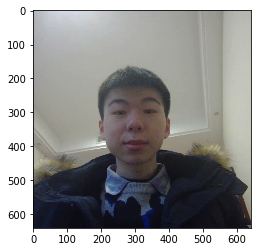

In [17]:
sendOutData = np.zeros(11)
sendOutData = sendOutData.astype(np.float32)

cam = cv2.VideoCapture(1)
cam.set(3, 640)
cam.set(4, 640)
flag_startCap = 0
resval = []
trans = torchvision.transforms.ToTensor()

while (cam.isOpened()):
    tmr_start = time.time()
    succ, img = cam.read()
    #img = cv2.flip(img, 1)
    #img = cv2.transpose(img)
    #img = cv2.flip(img, 0)
    cv2.imshow("camera",img)

    if (flag_startCap == 1):
        img128 = cv2.resize(img, (128,128))
        test_img128 = trans(img128)
        test_img128 = test_img128.unsqueeze(0)
        # if has face
        res_hasFace = hasFaceModel(test_img128).item()
        if (res_hasFace > 0.5):
            sendOutData[0] = res_hasFace
            # face rect
            res_facePose = v2_model1(test_img128).detach().numpy()
            res_facePose = res_facePose[0]
            centy = (res_facePose[0] + res_facePose[1])*0.5
            centx = (res_facePose[2] + res_facePose[3])*0.5
            r = max(centx-res_facePose[2], centy-res_facePose[0])
            if (r < 0.01):
                r = 0.01
            
            sendOutData[1] = centy
            sendOutData[2] = centx
            sendOutData[3] = r
            
            top = centy-r
            if (top<0.0):
                top = 0.01

            bottom = centy+r
            if (bottom>=1.0):
                bottom = 1.0

            left = centx-r
            if (left<0.0):
                left = 0.01

            right = centx+r
            if (right>=1.0):
                right = 1.0

            cut_img = img[int(top*639):int(bottom*639), int(left*639):int(right*639)]
            # face rot
            test_img64 = cv2.resize(cut_img, (64,64))
            test_img64 = trans(test_img64)
            test_img64 = test_img64.unsqueeze(0)
            res_faceRot = v2_model2(test_img64).detach().numpy()
            res_faceRot = res_faceRot[0]
            sendOutData[4] = res_faceRot[0]
            sendOutData[5] = res_faceRot[1]
            sendOutData[6] = res_faceRot[2]
            # emoji
            test_img256 = cv2.resize(cut_img, (256,256))
            test_img256 = trans(test_img256)
            test_img256 = test_img256.unsqueeze(0)
            res_emoji = v2_model3(test_img256).detach().numpy()
            res_emoji = res_emoji[0]
            sendOutData[7] = res_emoji[0]
            sendOutData[8] = res_emoji[1]
            sendOutData[9] = res_emoji[2]
            sendOutData[10] = res_emoji[3]
            
            #sendOutData[1:11] = low_pass(sendOutData[1:11], 8, 5.0)
            #cv2.rectangle(img, (int(left*639),int(top*639)),(int(right*639),int(bottom*639)),(0,0,255))
            #cv2.imshow("camera",img)
        else:
            sendOutData = np.zeros(11)
        #endif
        sendOutData = sendOutData.astype(np.float32)
        #tcp_socket = socket.socket(socket.AF_INET, socket.SOCK_STREAM)
        #tcp_socket.connect(('192.168.0.128', 9979))
        #tcp_socket.send(sendOutData.tobytes())
        #tcp_socket.close()
        b,g,r = cv2.split(img)  
        imgrgb = cv2.merge([r,g,b]) 
        plt.imshow(imgrgb)
        print(sendOutData)
        break;
    #endif
    
    keyPress = cv2.waitKey(1)
    if (keyPress == ord('r')):
        flag_startCap = 1
    elif (keyPress == ord('e')):
        flag_startCap = 0
        break;
    #endif
    
    tmr_end = time.time()
    while (tmr_end - tmr_start < 0.041):
        tmr_end = time.time()
    #end while
#end while
cam.release()

cv2.destroyAllWindows()
resval = np.array(resval)
np.savetxt('./script.txt', resval, delimiter=',')

In [34]:
ttt= np.array([1,2,3,4,5])
ttt[1:4] = ttt[1:4]+1
print(ttt)

[1 3 4 5 5]
